# ADSP Big Data and Cloud Computing Final Project
## Part 2
## Author: Jingkai Wang
### Date: Nov 30, 2024

In [1]:
# import all libraries here
import os
import subprocess
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import explode, length, count, year, expr, countDistinct
from pyspark.sql.functions import col, from_unixtime, to_date, regexp_extract, when
from pyspark.sql import SparkSession
from pyspark.sql.functions import max as spark_max, min as spark_min

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName('GCP Parquet') \
    .config('spark.sql.legacy.timeParserPolicy', 'LEGACY') \
    .getOrCreate()


spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 01:09:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/12/02 01:09:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/12/02 01:09:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/02 01:09:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## Load data into df

In [3]:
%%time
# define path
cleaned_data = 'gs://msca-bdp-students-bucket/notebooks/jingkaiw/cleaned_data'

# Read data   
df_languages = spark.read.parquet(os.path.join(cleaned_data, 'df_languages_cleaned'))
df_licenses = spark.read.parquet(os.path.join(cleaned_data, 'df_licenses_cleaned'))
df_commits = spark.read.parquet(os.path.join(cleaned_data, 'df_commits_cleaned'))
df_contents = spark.read.parquet(os.path.join(cleaned_data, 'df_contents_cleaned'))
df_files = spark.read.parquet(os.path.join(cleaned_data, 'df_files_cleaned'))


CPU times: user 14.2 ms, sys: 3 ms, total: 17.2 ms
Wall time: 10.1 s


### Step 3: What is the timeline of the data?  Do you see significant peaks and valleys?
- Do you see any data collection gaps?
- Do you see any outliers?  Remove obvious outliers before plotting the timeline
- Do you see any spikes?  Are these spikes caused by real activities / events?

In [4]:
# Show the first 5 rows of the data
df_commits.limit(5)

commit,author_name,author_email,author_date,committer_name,committer_email,committer_date,subject,message,repo_name
a72958075f3fb414a...,Christian Stigen ...,09cc4f1a800d3f82e...,2016-11-07 18:48:22,Christian Stigen ...,09cc4f1a800d3f82e...,2016-11-07 19:35:25,Reverts code to v...,Reverts code to v...,cslarsen/jp2a
b05aed33642d4f34d...,Baptiste,572d88c99bc07fa4b...,2017-01-17 17:15:20,Baptiste,572d88c99bc07fa4b...,2017-01-17 17:15:20,change copy,change copy,bjacquemet/challe...
85a482e45024ac189...,Mark,f1b5a91d4d6ad523f...,2016-04-16 19:11:35,Mark,f1b5a91d4d6ad523f...,2016-04-16 19:11:35,Added breakpoint ...,Added breakpoint ...,bhalash/prep
5e6e5d7e174e1cdd9...,Kaivalya Rawal,5ed355aa711409ee1...,2017-02-01 13:03:45,Kaivalya Rawal,5ed355aa711409ee1...,2017-02-01 13:03:45,add license,add license,kaivalyar/HelloWorld
a8d509dc1a10ff226...,Leonardo Lucena,da2dc9135c3950a07...,2015-02-09 20:28:09,Leonardo Lucena,da2dc9135c3950a07...,2015-02-09 20:28:09,Update README.md,Update README.md,potigol/SublimeTe...


In [5]:
# Extract Only date
df_commits = df_commits.withColumn('author_date_only', to_date(col('author_date'), 'yyyy-MM-dd')) \
                       .withColumn('committer_date_only', to_date(col('committer_date'), 'yyyy-MM-dd'))

# Aggregate date with only date and count
df_date = df_commits.groupBy('author_date_only') \
                    .agg(count('*').alias('count')) \
                    .orderBy('author_date_only')

# print out
df_date.limit(5)


author_date_only,count
1970-01-01,17
1970-01-02,3
1970-01-03,1
1970-01-04,4
1970-01-06,3


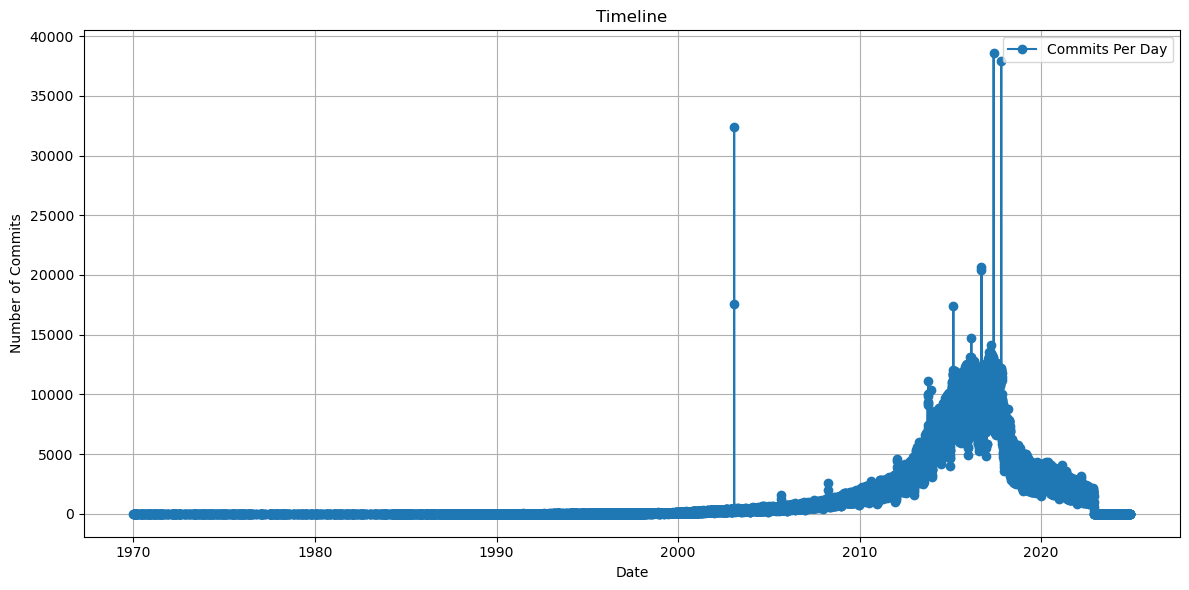

In [6]:
# Convert to Pandas 
df_date_pd = df_date.toPandas()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_date_pd['author_date_only'], 
         df_date_pd['count'], marker='o', linestyle='-', label='Commits Per Day')
plt.title('Timeline')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##### What is the timeline of the data? 
The timeline start before 1970, and extends to 2024. The most of the activity mainly forcus between 2008 to 2018.
##### Do you see significant peaks and valleys?¶
For the significant peaks, it is during 2015-2017, which exceed 30,000 commits. And as for the valleys, the significant valleys are very obvious at the timeline before 2000, the early timeline, and towards the end, after around 2018. 
##### Do you see any data collection gaps?
For the data collection before 2007, it indicates that the limited GitHub usage or incomplete data recording. Besides, after ~2018, a sharp decline in commits, which may because of the reduction in activity or gaps in the dataset.

#### Do you see any outliers? Remove obvious outliers before plotting the timeline

In [7]:
# Use describe to compare the median and mean
df_date_pd.describe()

,count
count,12916.000000
mean,2023.757510
std,3155.712893
min,1.000000
25%,18.000000
50%,431.000000
75%,2666.250000
max,38560.000000


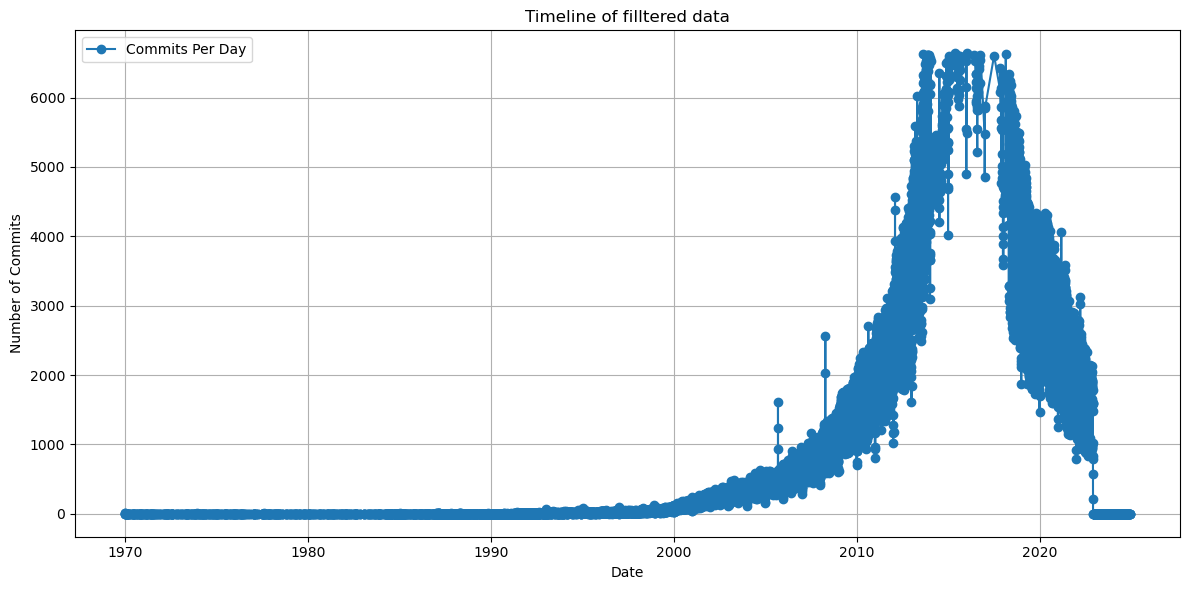

In [8]:
# Remove the outliers
# Compute statistics for commit counts
q1 = np.percentile(df_date_pd['count'], 25)
q3 = np.percentile(df_date_pd['count'], 75)
IQR = q3 - q1

# Define outlier thresholds
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Filter out outliers
df_date_pd_fil = df_date_pd[
    (df_date_pd['count'] >= lower_bound) & 
    (df_date_pd['count'] <= upper_bound)
]

# Make the plot again with filltered data
plt.figure(figsize=(12, 6))
plt.plot(df_date_pd_fil['author_date_only'], 
         df_date_pd_fil['count'], marker='o', linestyle='-', label='Commits Per Day')
plt.title('Timeline of filltered data')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Do you see any spikes? Are these spikes caused by real activities / events?

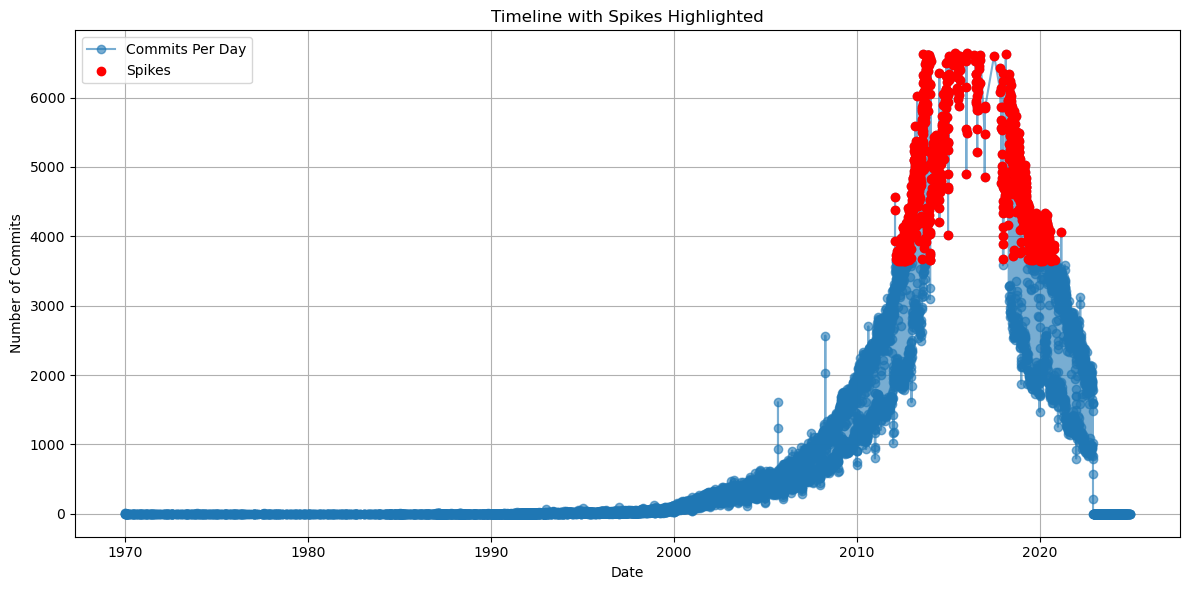

In [9]:
# Filter the spike dates 
spike = np.percentile(df_date_pd_fil['count'], 90)
spike_dates = df_date_pd_fil[df_date_pd_fil['count'] > spike]

# Plot the spikes
plt.figure(figsize=(12, 6))
plt.plot(df_date_pd_fil['author_date_only'], df_date_pd_fil['count'], label='Commits Per Day', linestyle='-', marker='o', alpha=0.6)
plt.scatter(spike_dates['author_date_only'], spike_dates['count'], color='red', label='Spikes', zorder=5)
plt.title('Timeline with Spikes Highlighted')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Most spikes appear to be caused by real activities, like collaborative development on popular repositories. And Some spikes in earlier years, may result from data inconsistencies or automated processes.**

### Step 4: What are the most popular programming languages on GitHub?
- Did the trend of most popular programming languages change over time?

In [10]:
# Display the original df
df_languages.show(5)

+--------------------+----------+-----+
|           repo_name|  language|bytes|
+--------------------+----------+-----+
|      nagypet/helios|         C| 1840|
|osaetinevbuoma/tw...|ApacheConf| 3073|
|kalimist123/adapt...|       CSS|   37|
|songzhw/android-t...|FreeMarker| 4195|
|gusztavvargadr/in...|      Ruby|63513|
+--------------------+----------+-----+
only showing top 5 rows



In [11]:
# Aggregate total bytes by language
df_languages_pop = df_languages.groupBy('language') \
                                 .agg(count('*').alias('language_count')) \
                                 .orderBy(col('language_count').desc())

# Display the top 10
df_languages_pop.show(10)


+----------+--------------+
|  language|language_count|
+----------+--------------+
|JavaScript|        109714|
|       CSS|         80595|
|      HTML|         77700|
|     Shell|         63961|
|    Python|         55297|
|      Ruby|         37438|
|      Java|         36749|
|       PHP|         34108|
|         C|         29251|
|       C++|         27592|
+----------+--------------+
only showing top 10 rows



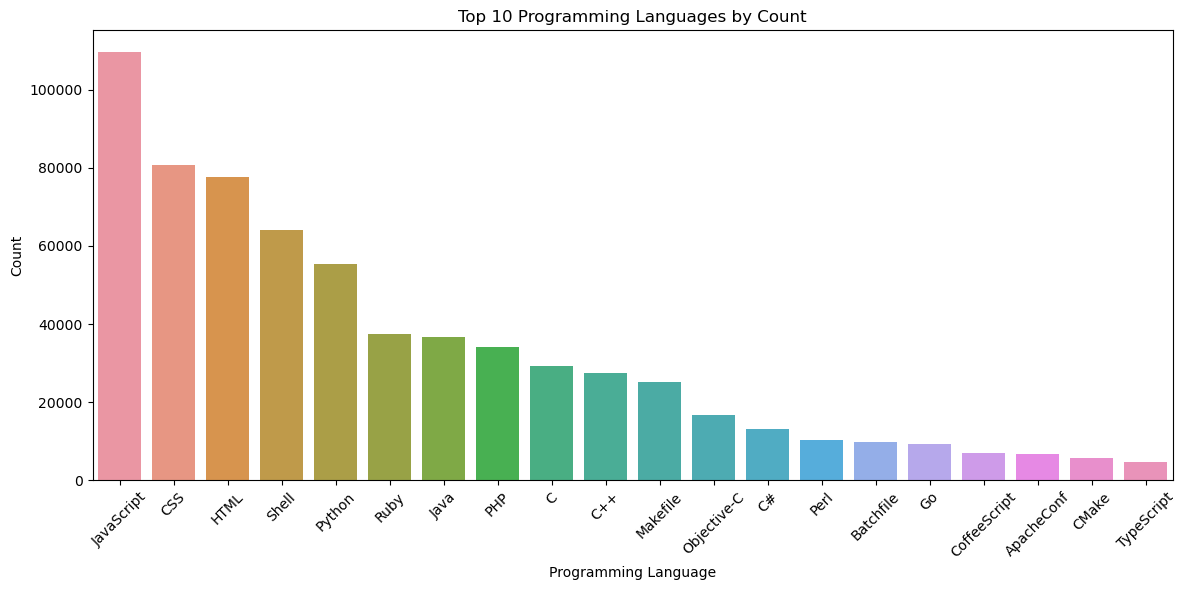

In [12]:
# Convert to pandas
df_languages_pop_pd = df_languages_pop.toPandas()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='language', y='language_count', data=df_languages_pop_pd[:20])
plt.title('Top 10 Programming Languages by Count')
plt.xlabel('Programming Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**`JavaScript`, `CSS`, `HTML`, `Shell`, and `Python` are the most popular programming languages on GitHub.**

In [13]:
# Extract year in df_commits and convert repo_name to string
df_commits = df_commits.withColumn('year', year(col('author_date_only')))

# Join the language with commits year
df_languages_year = df_languages.join(df_commits.select('repo_name', 'year'), 
                                      on='repo_name', how='inner')

# Aggregate the counts for years
df_languages_pop_trends = df_languages_year.groupBy('year', 'language') \
                                           .agg(count('*').alias('count')) \
                                           .orderBy('year', col('count').desc())

# Display top 10
df_languages_pop_trends.show(10)

+----+------------+-----+
|year|    language|count|
+----+------------+-----+
|1970|  JavaScript|   49|
|1970|        HTML|   48|
|1970|         CSS|   48|
|1970|       Shell|   47|
|1970|    Makefile|   47|
|1970|      Python|   47|
|1970|         C++|   47|
|1970|CoffeeScript|   47|
|1970|        VimL|   46|
|1970|    Assembly|   46|
+----+------------+-----+
only showing top 10 rows



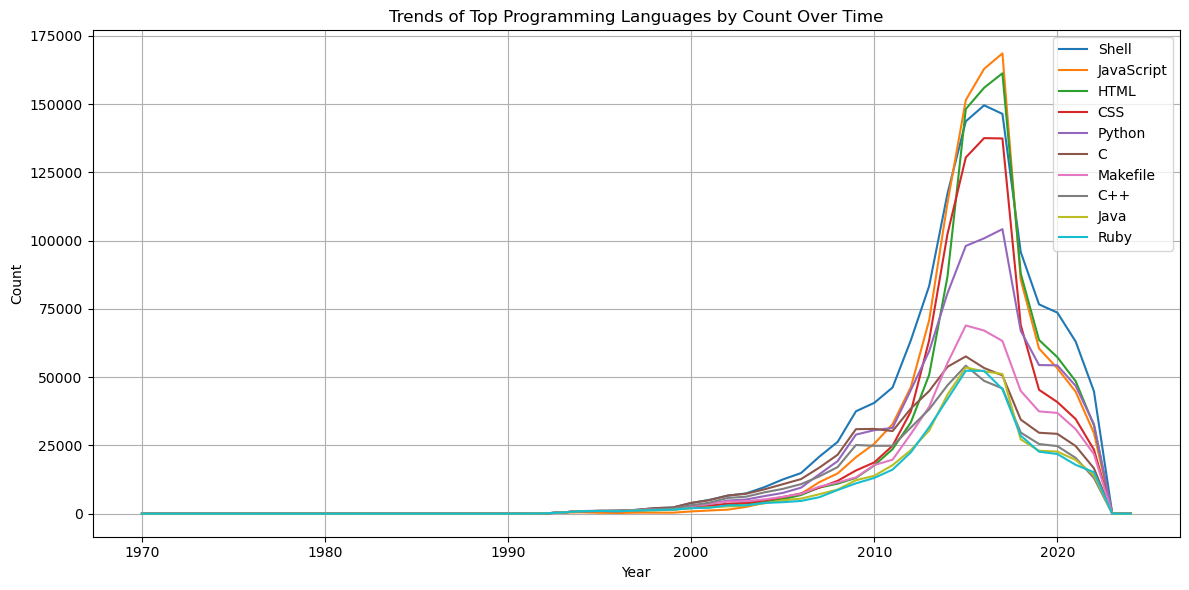

In [14]:
# Convert to Pandas
df_languages_pop_trends_pd = df_languages_pop_trends.toPandas()

# Filter for the top 10 languages
top_languages = df_languages_pop_trends_pd.groupby('language')['count'].sum().nlargest(10).index
df_top_language_trends = df_languages_pop_trends_pd[df_languages_pop_trends_pd['language'].isin(top_languages)]

# Plot trends over time
plt.figure(figsize=(12, 6))
for language in top_languages:
    language_data = df_top_language_trends[df_top_language_trends['language'] == language]
    plt.plot(language_data['year'], language_data['count'], label=language)

plt.title('Trends of Top Programming Languages by Count Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Ruby maintains consistent popularity until ~2015, and JavaScript and HTML exceed it.**

### Step 5: What is the distribution of licenses across GitHub repositories?
- Any certain programming languages that are more likely to be associated with a particular license?

In [15]:
# Show the df_license 
df_licenses.limit(5)

repo_name,license
otokunaga2/schedu...,artistic-2.0
denormal/perl-Cla...,artistic-2.0
vsbuffalo/bioinfo...,artistic-2.0
Arabidopsis-Infor...,artistic-2.0
oslugr/0agit,artistic-2.0


In [16]:
# Aggregate the licenses with count
df_lincenses_dis = df_licenses.groupBy('license') \
                               .count().orderBy(F.desc('count'))

df_lincenses_dis.show()

+------------+------+
|     license| count|
+------------+------+
|         mit|169267|
|  apache-2.0| 49659|
|     gpl-2.0| 34128|
|     gpl-3.0| 34065|
|bsd-3-clause| 15182|
|bsd-2-clause|  5429|
|   unlicense|  4596|
|    agpl-3.0|  4183|
|    lgpl-3.0|  3946|
|     cc0-1.0|  2698|
|     epl-1.0|  2386|
|    lgpl-2.1|  2272|
|     mpl-2.0|  1880|
|         isc|  1749|
|artistic-2.0|   814|
+------------+------+



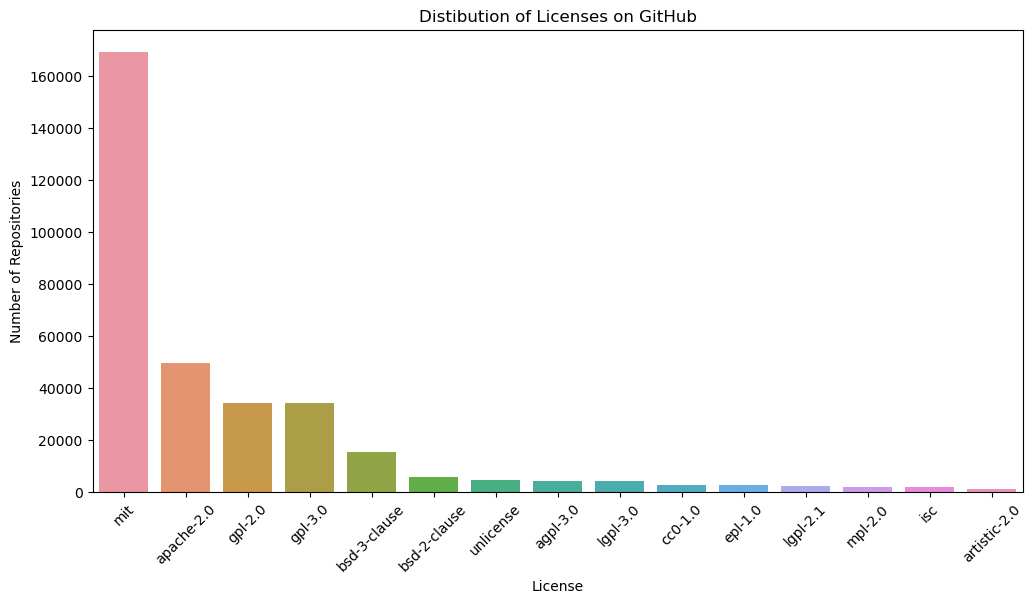

In [17]:
# Convert to Pandas for visualization
df_lincenses_dis_pd = df_lincenses_dis.toPandas()

# Plot the distribution of licenses
plt.figure(figsize=(12, 6))
sns.barplot(x='license', y='count', data=df_lincenses_dis_pd)
plt.title('Distibution of Licenses on GitHub')
plt.xlabel('License')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Join df_languages and df_licenses
df_licenses_lan = df_licenses.join(df_languages, on='repo_name', how='inner')

# Aggregate the count
df_licenses_lan = df_licenses_lan.groupBy('license', 'language') \
                                 .count().orderBy(F.desc('count'))

# Display
df_licenses_lan.show(10)

+----------+----------+-----+
|   license|  language|count|
+----------+----------+-----+
|       mit|JavaScript| 6809|
|       mit|       CSS| 4567|
|       mit|      HTML| 4434|
|       mit|      Ruby| 2562|
|       mit|     Shell| 2397|
|       mit|    Python| 2040|
|       mit|       PHP| 1634|
|apache-2.0|      Java| 1489|
|apache-2.0|JavaScript| 1307|
|apache-2.0|      HTML| 1229|
+----------+----------+-----+
only showing top 10 rows



In [19]:
# Convert Spark DataFrame to Pandas DataFrame
df_licenses_lan_pd = df_licenses_lan.toPandas()

# check the mean
df_licenses_lan_pd.describe()


,count
count,1864.000000
mean,42.150751
std,262.869392
min,1.000000
25%,1.000000
50%,3.000000
75%,10.250000
max,6809.000000


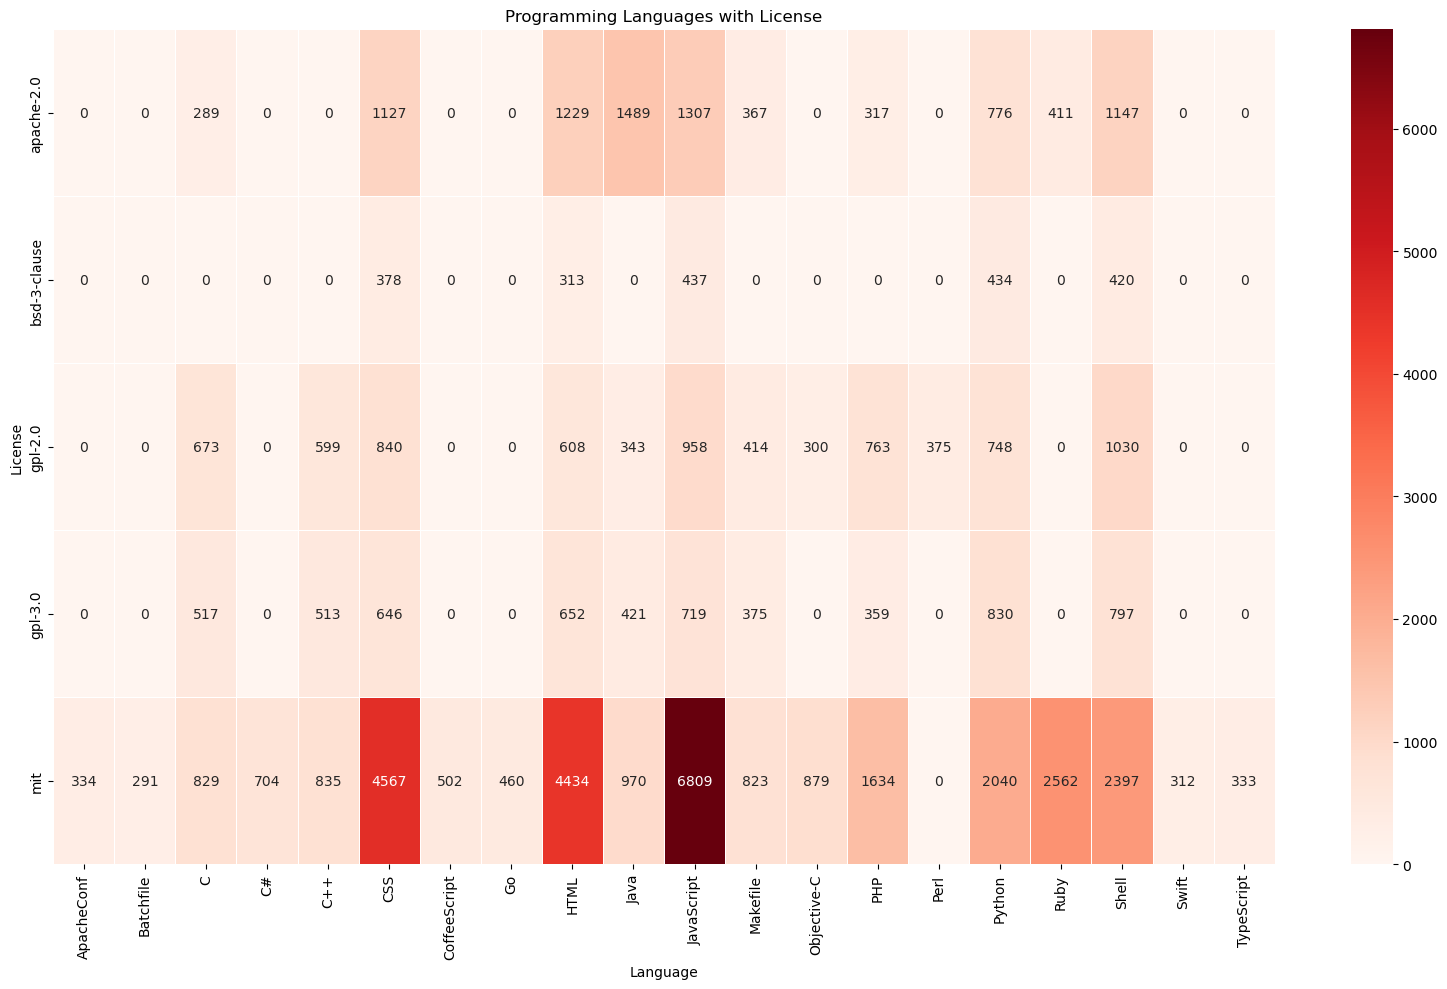

In [20]:
# filter the count > mean
df_licenses_lan_pd_fil = df_licenses_lan_pd[df_licenses_lan_pd['count'] >= 272]

# Create a pivot table for heatmap
df_pivot = df_licenses_lan_pd_fil.pivot(index='license', columns='language', values='count').fillna(0)

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(df_pivot, annot=True, fmt='.0f', cmap='Reds', linewidths=0.5)
plt.title('Programming Languages with License')
plt.xlabel('Language')
plt.ylabel('License')
plt.tight_layout()
plt.show()


**JavaScript,HTML, and CSS are more likely to be associated with mit.**

### Step 6: What can you tell about the most popular and most rapidly growing repositories?
- Is there certain technology that is driving popularity or explosive growth?
- Are these associated with Big TechLinks to an external site., who are open sourcing the technology?
- Are there any technological breakthroughs that are driving this brisk adoption?

In [21]:
# Aggregate the commit to find the most popular
df_repo = df_commits.groupBy('repo_name') \
                    .agg(count('commit').alias('commit_count'), 
                         countDistinct('author_email').alias('author_count')) \
                    .orderBy(F.desc('commit_count'))

df_repo.limit(10)


repo_name,commit_count,author_count
shenzhouzd/update,118733,2
chromium/chromium,68329,3676
duaneking/rocksta...,59817,2
Dark5ide/mycroft-...,52517,3
spiderworthy/linux,49332,1
MichaelQQ/Linux-PE,41336,5127
curtclifton/curtc...,38500,1
JurassicWordExcel...,37756,688
cloudfoundry/reli...,33825,40
nbari/homebrew-core,30648,2887


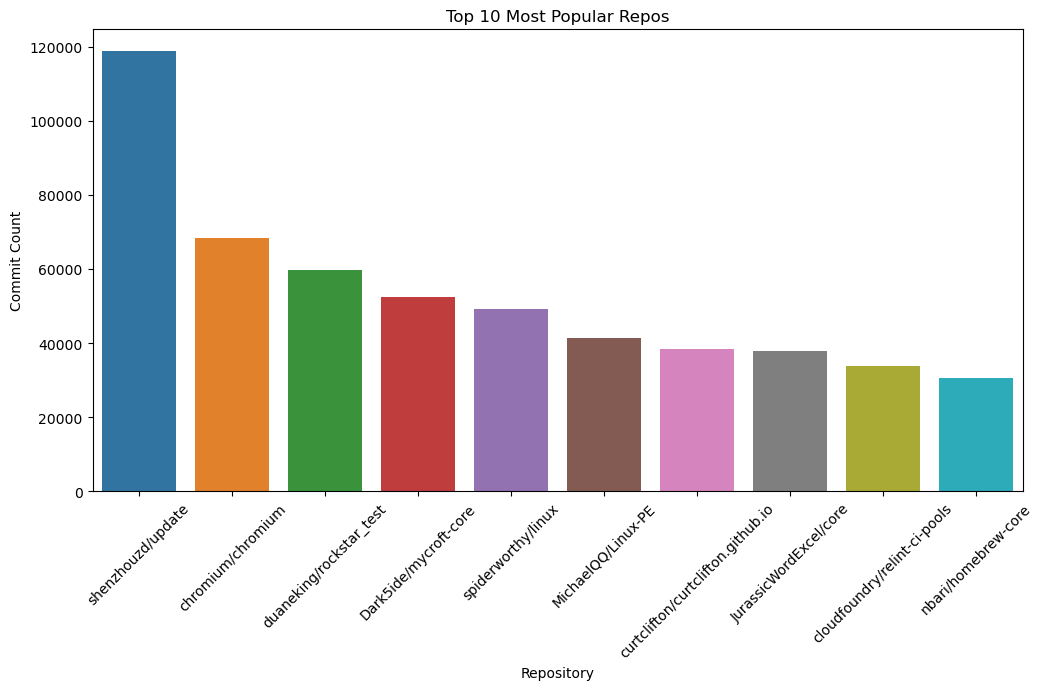

In [22]:
# convert to pandas
df_repo_pd = df_repo.toPandas()

# Plot the most popular repos
plt.figure(figsize=(12, 6))
sns.barplot(x='repo_name', y='commit_count', data=df_repo_pd[:10])
plt.title('Top 10 Most Popular Repos')
plt.xlabel('Repository')
plt.ylabel('Commit Count')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Aggregate to measure the growth
df_repo_growth = df_commits.groupBy('repo_name', 'year') \
                           .agg(count('commit').alias('commit_count')) \
                           .orderBy(col('repo_name'), col('year'))

# Calculate growth rate for each repository
df_repo_growth = df_repo_growth.groupBy('repo_name') \
                               .agg((spark_max('commit_count') - spark_min('commit_count')).alias('growth_count')) \
                               .orderBy(F.desc('growth_count'))

# Display
df_repo_growth.limit(10)


repo_name,growth_count
shenzhouzd/update,61896
Dark5ide/mycroft-...,52511
craigwmcclellan/c...,18249
IonicaBizau/I-Lov...,17024
curtclifton/curtc...,12582
chromium/chromium,12030
cloudfoundry/reli...,9552
openwrt-es/linux,8881
miatribe/pipvpspy,8486
opacapp/opacapp-c...,8392


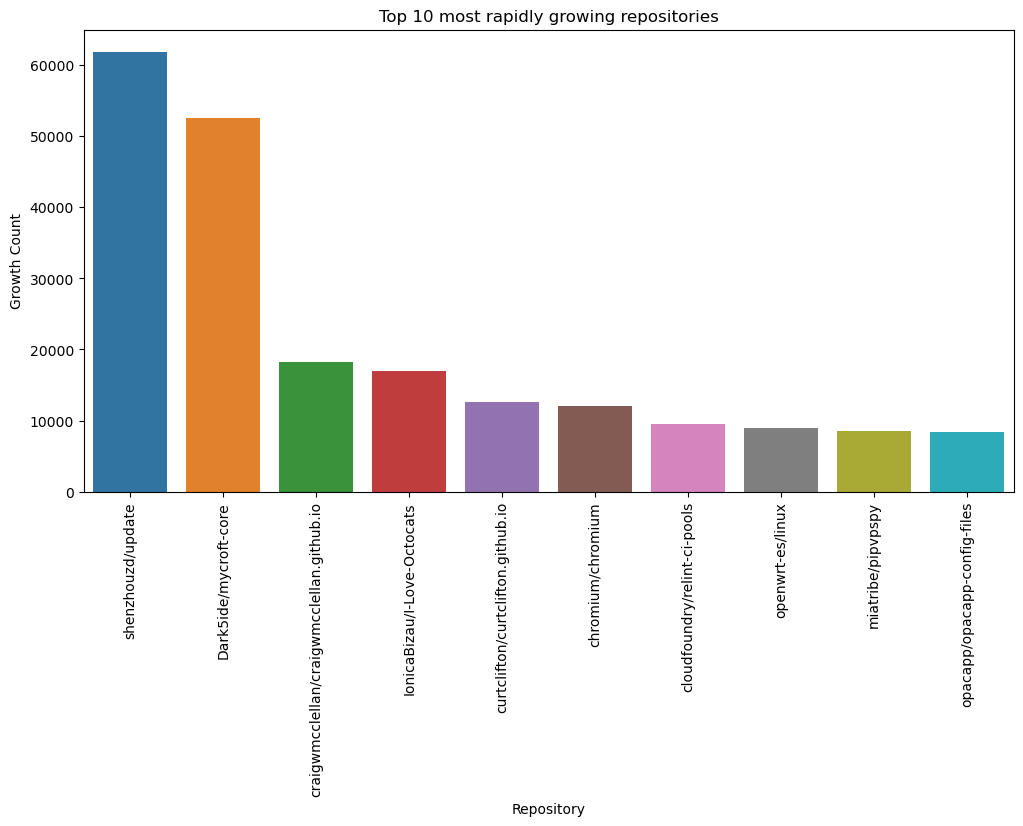

In [24]:
# convert to pandas
df_repo_growth_pd = df_repo_growth.toPandas()

# Plot the most rapidly growing repos
plt.figure(figsize=(12, 6))
sns.barplot(x='repo_name', y='growth_count', data=df_repo_growth_pd[:10])
plt.title('Top 10 most rapidly growing repositories')
plt.xlabel('Repository')
plt.ylabel('Growth Count')
plt.xticks(rotation=90)
plt.show()

**The most polular repos is `shenzhouzd/update`, most rapidly growing repos is also `shenzhouzd/update`**

#### Is there certain technology that is driving popularity or explosive growth?

In [25]:
# Join df_repo and df_languages
df_repo_lan = df_repo.join(df_languages, on='repo_name', how='inner')
df_repo_lan = df_repo_lan.groupBy('language') \
                         .agg(countDistinct('repo_name').alias('count')) \
                         .orderBy(F.desc('count'))

# Display
df_repo_lan.limit(10)


language,count
JavaScript,68080
CSS,50427
HTML,49280
Shell,38091
Python,34188
Ruby,22512
Java,21608
PHP,20708
C,16683
C++,15994


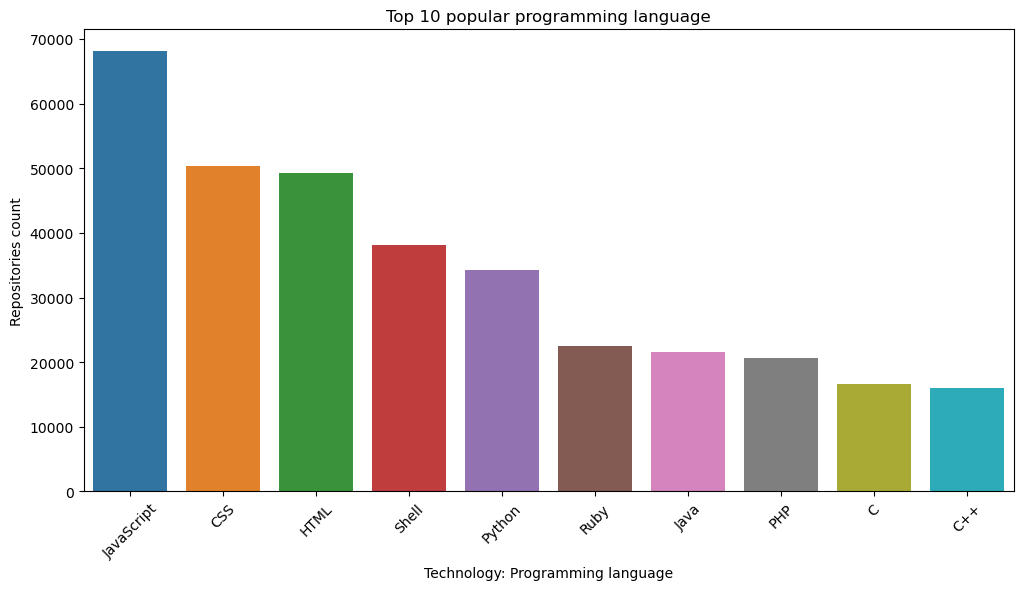

In [26]:
# convert to pandas
df_repo_lan_pd = df_repo_lan.toPandas()

# Plot the most popular languages
plt.figure(figsize=(12, 6))
sns.barplot(x='language', y='count', data=df_repo_lan_pd[:10])
plt.title('Top 10 popular programming language')
plt.xlabel('Technology: Programming language')
plt.ylabel('Repositories count')
plt.xticks(rotation=45)
plt.show()

#### Are these associated with Big TechLinks to an external site., who are open sourcing the technology?

In [27]:
# Create the big_tech list
big_tech_keywords = ['google', 'microsoft', 'facebook', 
                     'amazon', 'apple', 'meta', 'alphabet']

# Filter repositories associated with Big Tech
df_big = df_commits.withColumn(
    'big_tech', 
    when(col('repo_name').rlike('google'), 'Google')
    .when(col('repo_name').rlike('microsoft'), 'Microsoft')
    .when(col('repo_name').rlike('facebook'), 'Facebook')
    .when(col('repo_name').rlike('amazon'), 'Amazon')
    .when(col('repo_name').rlike('apple'), 'Apple')
    .when(col('repo_name').rlike('meta'), 'Meta')
    .when(col('repo_name').rlike('alphabet'), 'Alphabet')
).filter(col('big_tech').isNotNull()) # drop not big tech data

# Count total commits by Big Tech repositories
df_big_repo = df_big.groupBy('big_tech') \
                    .agg(count('repo_name').alias('count')) \
                    .orderBy(F.desc('count'))

df_big_repo.limit(10)


big_tech,count
Google,149695
Meta,86154
Facebook,26388
Apple,21157
Microsoft,6366
Amazon,4683
Alphabet,969


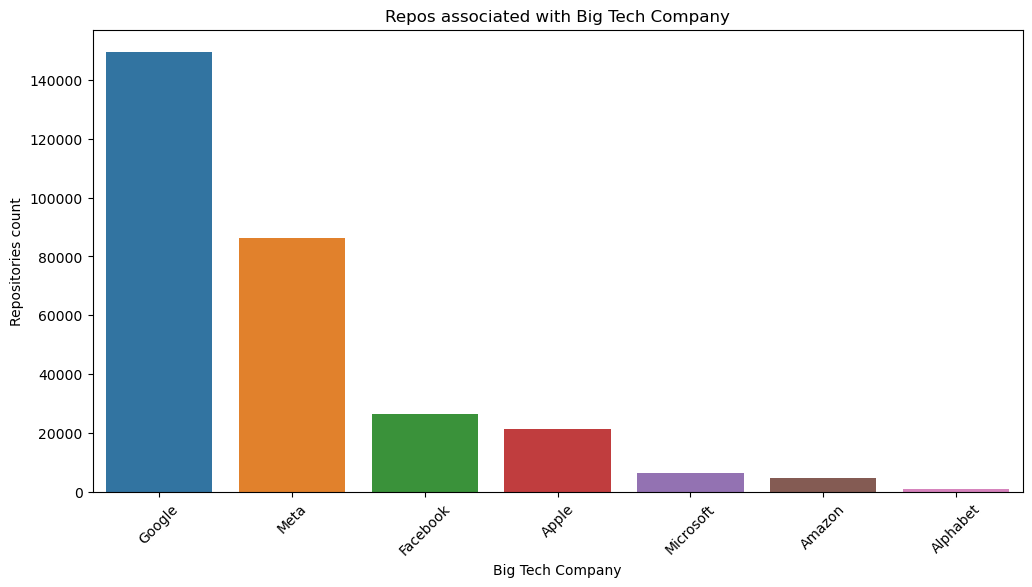

In [28]:
# convert to pandas
df_big_repo_pd = df_big_repo.toPandas()

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='big_tech', y='count', data=df_big_repo_pd)
plt.title('Repos associated with Big Tech Company')
plt.xlabel('Big Tech Company')
plt.ylabel('Repositories count')
plt.xticks(rotation=45)
plt.show()

#### Are there any technological breakthroughs that are driving this brisk adoption?

In [29]:
# Analyze commit messages for keywords indicating breakthroughs
tech_break = ['AI', 'blockchain', 'cloud', 'quantum', 
                'machine learning', 'transformer', 'neural network']

# Add a column to identify which breakthrough keyword is mentioned
df_tech_break = df_commits.withColumn(
    'tech_break',
    when(col('message').rlike('AI'), 'AI')
    .when(col('message').rlike('blockchain'), 'Blockchain')
    .when(col('message').rlike('cloud'), 'Cloud')
    .when(col('message').rlike('quantum'), 'Quantum')
    .when(col('message').rlike('machine learning'), 'Machine Learning')
    .when(col('message').rlike('transformer'), 'Transformer')
    .when(col('message').rlike('neural network'), 'Neural Network')
).filter(col('tech_break').isNotNull())

# Aggregate by repository and keyword
df_tech_break_repo = df_tech_break.groupBy('tech_break') \
                                  .agg(F.count('message').alias('count')
).orderBy(F.desc('count'))

# Show the most mentioned breakthroughs
df_tech_break_repo.show()


+----------------+-----+
|      tech_break|count|
+----------------+-----+
|           Cloud|60955|
|              AI|57043|
|     Transformer| 4334|
|      Blockchain| 1585|
|         Quantum| 1352|
|  Neural Network|  388|
|Machine Learning|  302|
+----------------+-----+



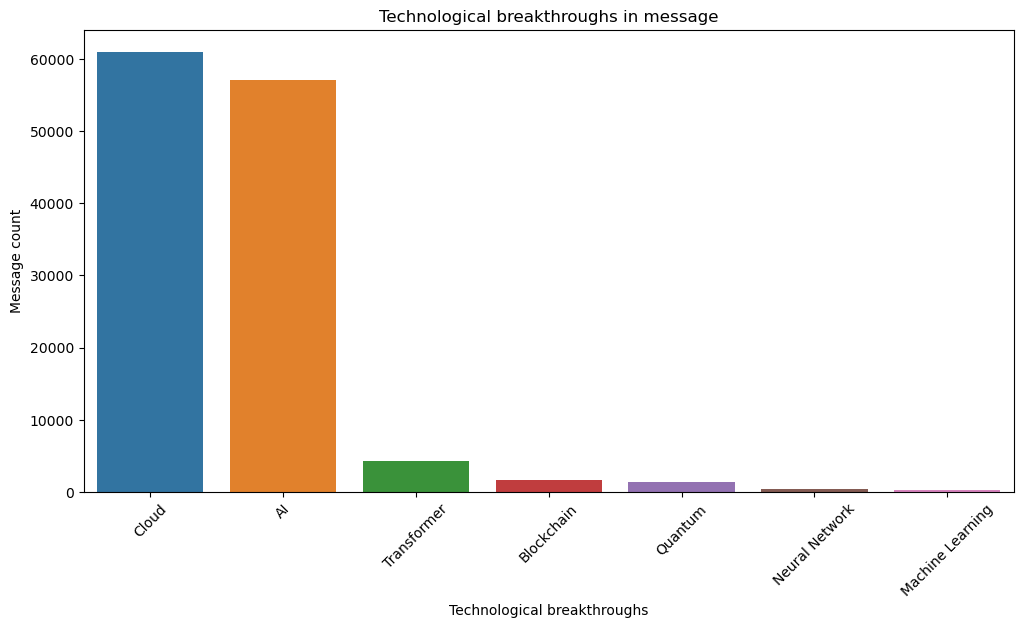

In [30]:
# convert to pandas
df_tech_break_repo_pd = df_tech_break_repo.toPandas()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='tech_break', y='count', data=df_tech_break_repo_pd)
plt.title('Technological breakthroughs in message')
plt.xlabel('Technological breakthroughs')
plt.ylabel('Message count')
plt.xticks(rotation=45)
plt.show()

In [31]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sun, 01 December 2024 19:13:09'